In [1]:
import os
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, auc, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.multioutput import MultiOutputClassifier
import pandas as pd
import numpy as np
import itertools
import seaborn as sns

from monai.data import (
    CSVDataset
)
from sklearn.metrics import accuracy_score
from collections import OrderedDict

ModuleNotFoundError: No module named 'sklearn'

In [13]:
import sys; sys.path.append("../")
from data_loading.data_transformations import TasksToLabelsD, TabularNormalisationD
from utils.utils import update_results_from_report, precision_recall_auc, get_max_ordinal
from models.kappa_metric import cpmp_qwk

from argparse import Namespace
args = Namespace(**{
    "nfolds": 5,
    "fold": 0,
    "seed": 42,
    "data": "/data/oleksii/datasets/ALTA-Lesions-Dataset/classification/preprocessed",
    "split": "/data/oleksii/datasets/ALTA-Lesions-Dataset/classification/splits_5_folds_seed_42",

    "use_prostatitis": True,
    "task": "binary",
    "feature_mode": "standard",
    })


def get_data_config(args):
    if args.use_prostatitis:
        args.class_dict = {
            0: "healthy",
            1: "prostatitis",
            2: "GS6",
            3: "GS7a",
            4: "GS7b",
            5: "GS8",
            6: "GS9_10",
        }
        args.class_names = ['prostatitis', 'GS6', 'GS7a', 'GS7b', 'GS8', 'GS9_10']
        args.csPCa_args = [3, 4, 5, 6]
    else:
        args.class_dict = {
            0: "healthy",
            1: "GS6",
            2: "GS7a",
            3: "GS7b",
            4: "GS8",
            5: "GS9_10",
        }
        args.csPCa_args = [2, 3, 4, 5]
        args.class_names = ['GS6', 'GS7a', 'GS7b', 'GS8', 'GS9_10']

    if args.feature_mode == "standard":
        args.tabular_features = ['age',
                            'birth_year',
                            'PatientWeight',
                            'PatientSize',
                            'PSA_value',
                            'BMI']
    elif args.feature_mode == "extended":
        args.tabular_features = ['age',
                            'age_prev',
                            'birth_year',
                            'PatientWeight',
                            'PatientSize',
                            'PSA_value',
                            'PSA_value_prev',
                            'BMI']
    elif args.feature_mode == "extended_prev":
        args.tabular_features = ['age',
                            'age_prev',
                            'age_prev_prev',
                            'birth_year',
                            'PatientWeight',
                            'PatientSize',
                            'PSA_value',
                            'PSA_value_prev',
                            'PSA_value_prev_prev',
                            'BMI']
    elif args.feature_mode == "no_psa":
        args.tabular_features = ['age',
                            'birth_year',
                            'PatientWeight',
                            'BMI']

    args.col_names = ['t2w', 'adc', 'dwi'] + args.class_names + args.tabular_features + [f + "_MISSING" for f in args.tabular_features]
    
    return args

args = get_data_config(args)


In [14]:
fold = 0
train_split = CSVDataset(
      os.path.join(args.split, f"fold_{fold}", "train.csv"),
      col_names=args.col_names,
      kwargs_read_csv={"sep": ";"},
  )
valid_split = CSVDataset(
      os.path.join(args.split, f"fold_{fold}", "valid.csv"),
      col_names=args.col_names,
      kwargs_read_csv={"sep": ";"},
  )
test_split = CSVDataset(
    os.path.join(args.split, "test.csv"),
    col_names=args.col_names,
    kwargs_read_csv={"sep": ";"},
    )


In [15]:
# tabular_transform = TabularNormalisationD(tabular_meta_data=tabular_meta_data, tabular_features=args.tabular_features, name="tabular")
label_transform = TasksToLabelsD(args.class_names, task=args.task, name="label")

In [16]:
total_train_cohort = pd.DataFrame([label_transform(i) for i in train_split] + [label_transform(i) for i in valid_split])

In [17]:
total_train_cohort.columns

Index(['t2w', 'adc', 'dwi', 'prostatitis', 'GS6', 'GS7a', 'GS7b', 'GS8',
       'GS9_10', 'age', 'birth_year', 'PatientWeight', 'PatientSize',
       'PSA_value', 'BMI', 'age_MISSING', 'birth_year_MISSING',
       'PatientWeight_MISSING', 'PatientSize_MISSING', 'PSA_value_MISSING',
       'BMI_MISSING', 'label'],
      dtype='object')

In [18]:
total_train_cohort[total_train_cohort['label'] == 0]['PatientSize'].to_numpy()

array([1.78, 0.  , 1.65, ..., 0.  , 0.  , 0.  ])

In [19]:
total_train_cohort.columns

Index(['t2w', 'adc', 'dwi', 'prostatitis', 'GS6', 'GS7a', 'GS7b', 'GS8',
       'GS9_10', 'age', 'birth_year', 'PatientWeight', 'PatientSize',
       'PSA_value', 'BMI', 'age_MISSING', 'birth_year_MISSING',
       'PatientWeight_MISSING', 'PatientSize_MISSING', 'PSA_value_MISSING',
       'BMI_MISSING', 'label'],
      dtype='object')

In [20]:
# final[final['age'] < 25]


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

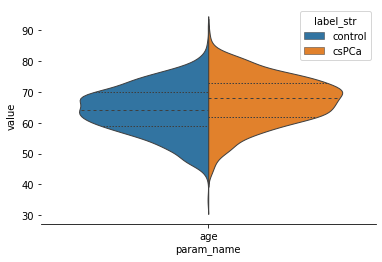

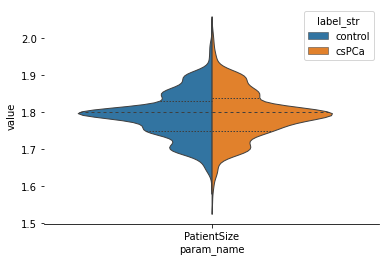

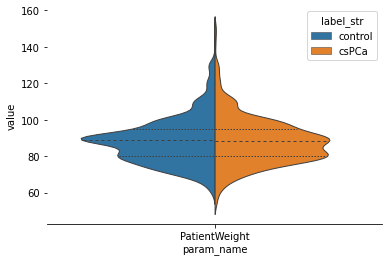

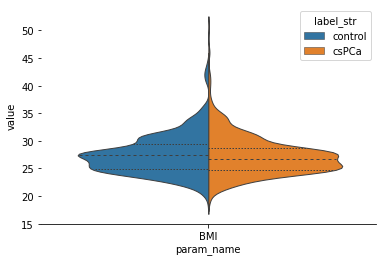

In [21]:
import matplotlib.pyplot as plt

clinical_parameters = ["age", "PatientSize", "PatientWeight", "BMI"]
for i, cp in enumerate(clinical_parameters):
    plt.figure(i)
    pw = total_train_cohort[(total_train_cohort[cp] > 0)]
    pw.loc[pw["label"]==0, "label_str"] = "control"
    pw.loc[pw["label"]==1, "label_str"] = "csPCa"
    pw.loc[:, 'value'] = pw[cp]
    pw.loc[:, 'param_name'] = cp
    sns.violinplot(data=pw, x='param_name', y="value", hue="label_str",
                   split=True, inner="quart", linewidth=1,
    #                palette={"control": "b", "csPCa": ".85"}
                  )
    sns.despine(left=True)

## Check predictions probs

In [78]:
pred_df = pd.read_csv("/hdd/drive1/oleksii/projects/nnUNet_prostate_classification/test_pred.csv", sep=";")
pred_df['pred_class'] = pred_df['pred_class'].astype('str')

In [37]:
pred_df[pred_df['pred_class']==1]['pred']

Series([], Name: pred, dtype: float64)

<AxesSubplot:xlabel='param_name', ylabel='pred'>

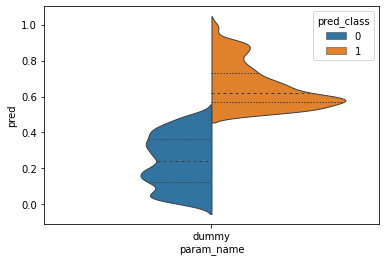

In [52]:
pred_df.loc[:, 'param_name'] = 'dummy'

sns.violinplot(data=pred_df, x="param_name", y="pred", hue="pred_class", cut=2, bw = 0.2,
               split=True, inner="quart", linewidth=1)

In [45]:
sns.violinplot

<function seaborn.categorical.violinplot(*, x=None, y=None, hue=None, data=None, order=None, hue_order=None, bw='scott', cut=2, scale='area', scale_hue=True, gridsize=100, width=0.8, inner='box', split=False, dodge=True, orient=None, linewidth=None, color=None, palette=None, saturation=0.75, ax=None, **kwargs)>

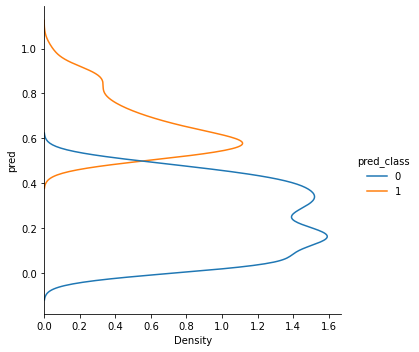

In [93]:
sns.displot(data=pred_df, y="pred", hue="pred_class", kind="kde")
# for p in ax.patches:  # turn the histogram upside down
#     p.set_height(-p.get_height())
# for l in ax.lines:  # turn the kde curve upside down
#     l.set_ydata(-l.get_ydata())

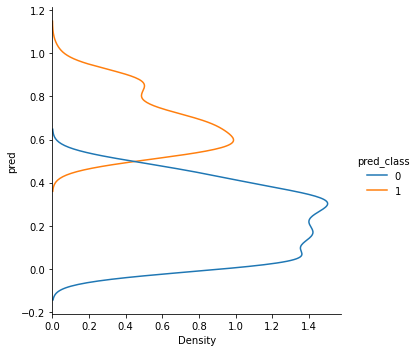

In [97]:
sns.displot(data=pred_df[pred_df['age'] > 65], y="pred", hue="pred_class", kind="kde")

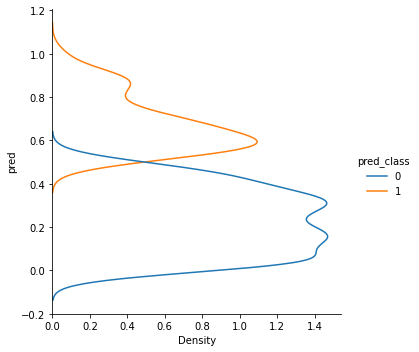

In [98]:
sns.displot(data=pred_df[(pred_df['age'] < 65 ) != (pred_df['age'] > 0) ], y="pred", hue="pred_class", kind="kde")

In [99]:
def validate(y_true, y_pred, y_pred_prob, args):
    out_dict = OrderedDict([])

    if args.task == "multiclass":
        acc_metric = accuracy_score(y_true, y_pred)
    
        y_pred_csPCa = np.sum(y_pred_prob[..., args.csPCa_args], axis=1, keepdims=True)
        y_pred_csPCa_binary = (y_pred_csPCa > 0.5).astype(int)
        y_csPCa = (y_true >= 3).astype(int)
    
#         print(y_csPCa.shape, y_pred_csPCa_binary.shape )
        report_csPCa = classification_report(y_csPCa, y_pred_csPCa_binary,
                                             target_names=["non-significant", "csPCa"], output_dict=True)
        report = classification_report(y_true, y_pred,
                                       target_names=args.class_dict.values(), output_dict=True)
    
        auc_csPCa = roc_auc_score(y_csPCa, y_pred_csPCa)
        pr_auc_csPCa = precision_recall_auc(y_csPCa, y_pred_csPCa)
        val_auc_result = roc_auc_score(y_true.tolist(), y_pred_prob, average='macro', multi_class='ovr')
        kappa = cpmp_qwk(y_true, y_pred, max_rat=y_pred_prob.shape[1] - 1)

        
        val_metrics = OrderedDict([
            ('auc', val_auc_result),
            ('accuracy', acc_metric),
            ('kappa', kappa),
            ('csPCa/auc', auc_csPCa),
            ('csPCa/pr_auc', pr_auc_csPCa)])
    
        out_dict.update(val_metrics)
        out_dict = update_results_from_report(report, out_dict)
        out_dict = update_results_from_report(report_csPCa, out_dict)
        
    elif args.task == "ordinal":
        # acc_value = accuracy_score(y_true, y_pred_act)
        # hamming_loss_value = hamming_loss(y_true, y_pred_act)

        y_pred_prob_test = np.swapaxes(np.stack(y_pred_prob),0,1)[:,:,1]
        
        # get negative class by substracting the prositives labels 
        #         negative_class_pred = 1 - np.mean(y_pred_prob_test, axis=1, keepdims=True)
        #         y_pred_with_neg = np.concatenate([negative_class_pred, y_pred_prob_test], axis=1)
        #         y_pred_with_neg = (y_pred_with_neg >= 0.5).astype(int)
        #         y_true_with_neg = (np.sum(y_true, axis=1, keepdims=True) < 1).astype(int)
        #         y_true_with_neg = np.concatenate([y_true_with_neg, y_true], axis=1)

        #         report = classification_report(y_true_with_neg.tolist(), y_pred_with_neg.tolist(),
        #                                        target_names=args.class_dict.values(), output_dict=True)
        
        val_auc_result = roc_auc_score(y_true, y_pred_prob_test, average='macro', multi_class='ovr')

        y_pred_class_idx = get_max_ordinal(y_pred)
        y_true_class_idx = get_max_ordinal(y_true)
        report = classification_report(y_true_class_idx.tolist(), y_pred_class_idx.tolist(),
                                       target_names=args.class_dict.values(), output_dict=True)
        
        y_pred_csPCa = (y_pred_class_idx > 0.5).astype(int)
        y_csPCa = (y_true_class_idx >= 3).astype(int)
        report_csPCa = classification_report(y_csPCa, y_pred_csPCa,
                                             target_names=["non-significant", "csPCa"], output_dict=True)
        
        acc_metric = accuracy_score(y_true_class_idx, y_pred_class_idx)
        kappa = cpmp_qwk(y_true_class_idx, y_pred_class_idx, max_rat=y_pred.shape[1])

        val_metrics = OrderedDict([
            ('accuracy', acc_metric),
            ('kappa', kappa),
            ('auc', val_auc_result),
            # ('csPCa/auc', auc_csPCa),
            # ('csPCa/pr_auc', pr_auc_csPCa)]
        ])
        out_dict.update(val_metrics)
        out_dict = update_results_from_report(report, out_dict)
        out_dict = update_results_from_report(report_csPCa, out_dict)
    
    elif args.task == "binary":
        acc_value = accuracy_score(y_true, y_pred)

        report_csPCa = classification_report(y_true, y_pred,
                                             target_names=["non-significant", "csPCa"],
                                             labels=[0, 1], output_dict=True)
        auc_csPCa = roc_auc_score(y_true, y_pred_prob[:,1])
        pr_auc_csPCa = precision_recall_auc(y_true, y_pred_prob[:,1])

        val_metrics = OrderedDict([
            ('accuracy', acc_value),
            ('csPCa/auc', auc_csPCa),
            ('csPCa/pr_auc', pr_auc_csPCa)])

        out_dict.update(val_metrics)
        out_dict = update_results_from_report(report_csPCa, out_dict)
    return out_dict